# MNIST CNN

Trains a simple convnet on the MNIST dataset. Gets to 99.25% test accuracy after 12 epochs with plenty of margin for parameter tuning. This takes 16 seconds per epoch on a GRID K520 GPU and 19 seconds on GTX 1060.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7)
%matplotlib inline

import tensorflow
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,BatchNormalization, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K

In [2]:
batch_size = 128
num_classes = 10
epochs = 50

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Format data for training
Our neural-network does not need a single 784 dimensional vector. However,we'll scale the inputs to be in the range [0-1] rather than [0-255]

In [3]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Build the CNN

Regularization - BatchNormalization and Dropouts are optional

In [4]:
#Using Keras Sequential API
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0

## Compile the model
Keras is using TensorFlow as a backend. 

When compiling a model, Keras asks you to specify your **loss function** and your **optimizer**. The loss function we'll use here is called *categorical crossentropy*, and is a loss function well-suited to comparing two probability distributions.

In [6]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

## Callbacks


[EarlyStopping](https://keras.io/api/callbacks/early_stopping/) Stop training when a monitored metric has stopped improving.

[ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

In [7]:
my_callbacks = [
    EarlyStopping(patience=3),
    ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5', 
                    save_best_only=True,
                    mode='max',
                    monitor='val_accuracy'),
    TensorBoard(log_dir='logs'),
]

## Train Model
Feed the training data loaded in earlier into this model and it will learn to classify digits

In [8]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=my_callbacks)

Epoch 1/50
469/469 [==============================] - 30s 42ms/step - loss: 2.3295 - accuracy: 0.1825 - val_loss: 2.0079 - val_accuracy: 0.5473
Epoch 2/50
469/469 [==============================] - 9s 19ms/step - loss: 1.8542 - accuracy: 0.3702 - val_loss: 1.4220 - val_accuracy: 0.7278
Epoch 3/50
469/469 [==============================] - 5s 11ms/step - loss: 1.5318 - accuracy: 0.5025 - val_loss: 1.0825 - val_accuracy: 0.7914
Epoch 4/50
469/469 [==============================] - 5s 10ms/step - loss: 1.2940 - accuracy: 0.5874 - val_loss: 0.8549 - val_accuracy: 0.8286
Epoch 5/50
469/469 [==============================] - 4s 9ms/step - loss: 1.1233 - accuracy: 0.6430 - val_loss: 0.7062 - val_accuracy: 0.8486
Epoch 6/50
469/469 [==============================] - 3s 7ms/step - loss: 0.9869 - accuracy: 0.6865 - val_loss: 0.6032 - val_accuracy: 0.8628
Epoch 7/50
469/469 [==============================] - 3s 7ms/step - loss: 0.8893 - accuracy: 0.7179 - val_loss: 0.5312 - val_accuracy: 0.8732
E

## Evaluate performance

In [15]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score)

ValueError: in user code:

    File "c:\Users\nuke2\miniconda3\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\nuke2\miniconda3\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\nuke2\miniconda3\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\nuke2\miniconda3\lib\site-packages\keras\engine\training.py", line 1667, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\nuke2\miniconda3\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\nuke2\miniconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\nuke2\miniconda3\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\nuke2\miniconda3\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\nuke2\miniconda3\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\nuke2\miniconda3\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 10) are incompatible


## Loss curve

Text(0.5, 1.0, 'Loss Curves')

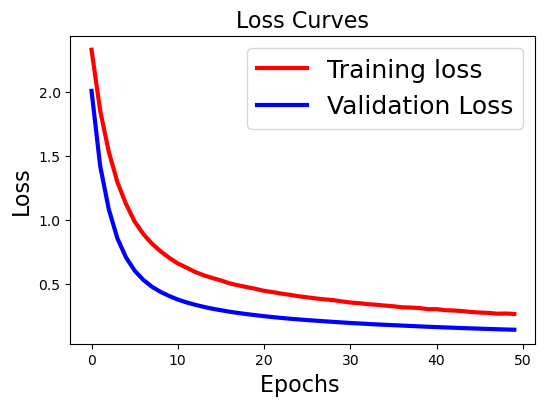

In [14]:
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

## Inspect the output

Inspect the output and look at some examples it gets right, and some examples it gets wrong. The predict_classes function outputs the highest probability class according to the trained classifier for each input example.

In [16]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
predicted_classes = np.argmax(model.predict(x_test), axis=-1)

#print(predicted_classes)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

#print(correct_indices)
#print(incorrect_indices)

313/313 [==============================] - 1s 2ms/step


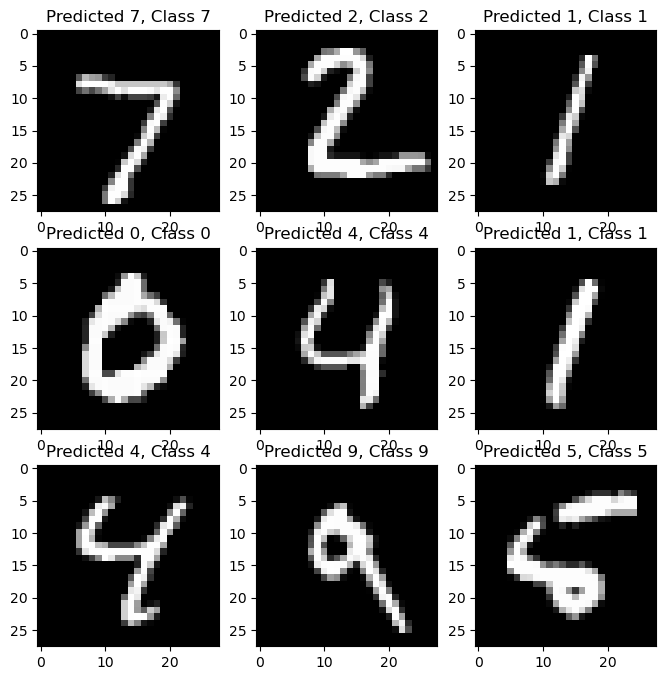

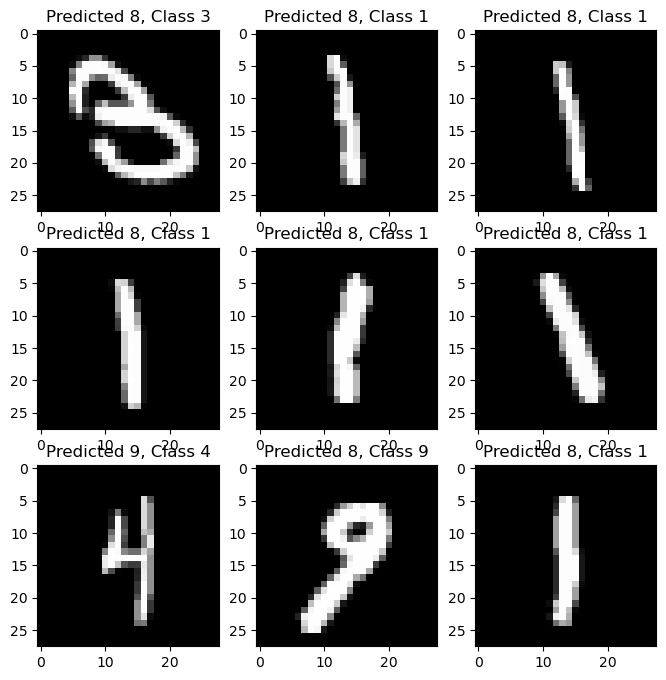

In [17]:
#some of the correct results
plt.figure(figsize=(8,8))
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
#some of the incorrect predictions
plt.figure(figsize=(8,8))
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

## <span style="color:cornflowerblue">Exercise:</span>

<font color="red">Exercise: Improve the accuracy score of the CNN by :
    1 ) adding more layers 2) hyperparameter optimization</font>